In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from filterpy.kalman import IMMEstimator
from filterpy.common import kinematic_kf
from target import TargetOnTrajectory, preprocess_trajectory_data
from target.common import constant_turn_rate_matrix, GenericTarget, DefinedTarget
from tracking import ConstantUpdatePolicy
from radar import Sensor, Radar2D
from simulation import simulation_loop
from plotting import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [147]:
dt = 0.01
traj = pd.read_csv('trajectories/traj_6.csv').to_numpy()[:, :2]
order=2
dim=2
f1 = np.array([
    [1, dt, dt**2/2],
    [0, 1, dt],
    [0, 0, 1]
])
f2 = np.copy(f1)
f2[2, 2] = 0
Z = np.zeros((3, 3))
Fcv = np.concatenate((np.concatenate((f1, Z), axis=0), np.concatenate((Z, f1), axis=0)), axis=1)
Fca = np.concatenate((np.concatenate((f2, Z), axis=0), np.concatenate((Z, f2), axis=0)), axis=1)
Fct1 = constant_turn_rate_matrix(0.2, dt)
Fct2 = constant_turn_rate_matrix(-0.2, dt)


q1 = np.diag([0.01, 0.0010, 0.0001])*1e-3
Qcv = np.concatenate((np.concatenate((q1, Z), axis=0), np.concatenate((Z, q1), axis=0)), axis=1)


q2 = np.diag([0.1, 0.010, 0])
Qca = np.concatenate((np.concatenate((q2, Z), axis=0), np.concatenate((Z, q2), axis=0)), axis=1)

Qct = Qcv

In [148]:
x0 = np.array([0, 300, 0, 0, 0, 0])

kf_cv = kinematic_kf(dim=dim, order=order, dt=dt)
kf_cv.Q = Qcv
kf_cv.F = Fca


kf_ca = kinematic_kf(dim=dim, order=order, dt=dt)
kf_ca.Q = Qca
kf_ca.F = Fca

kf_ct1 = kinematic_kf(dim=dim, order=order, dt=dt)
kf_ct1.Q = Qct
kf_ct1.F = Fct1

kf_ct2 = kinematic_kf(dim=dim, order=order, dt=dt)
kf_ct2.Q = Qct
kf_ct2.F = Fct2

filters = [kf_cv, kf_ct1, kf_ct2]
n_filters = len(filters)
p_switch = 0.03
'''
probs = np.ones((n_filters,)*2)*p_switch/n_filters
np.fill_diagonal(probs, (1-p_switch,)*n_filters)
'''
probs = np.array([
    [1-p_switch, p_switch/2, p_switch/2],
    [p_switch, 1-p_switch, 0],
    [p_switch, 0, 1-p_switch]
])
mu = np.ones(probs.shape[0])/probs.shape[0]


horizon= traj.shape[0] - 1
# horizon=5000

In [149]:
tracker = IMMEstimator(filters, mu, probs)
target = TargetOnTrajectory(preprocess_trajectory_data(traj, dim=dim, order=order))
# target = DefinedTarget(x0, st_models={0: Fcv, 1000: Fct1, 1500: Fcv, 2500: Fct1, 3500: Fcv}, p_noises={0: Qcv})
radar = Radar2D(
    sn0=1000000.0,
    beamwidth=np.pi/2,
    prob_f=1e-4,
    order=2,
)

update_policy = ConstantUpdatePolicy(100)

In [156]:
target.reset()
update_policy.reset()
for filt in tracker.filters:
    filt.x = target.x
    filt.P = np.diag([1, 1000, 0, 1, 1000, 0])

data = simulation_loop(target, radar, tracker, update_policy, horizon)

<IPython.core.display.Javascript object>


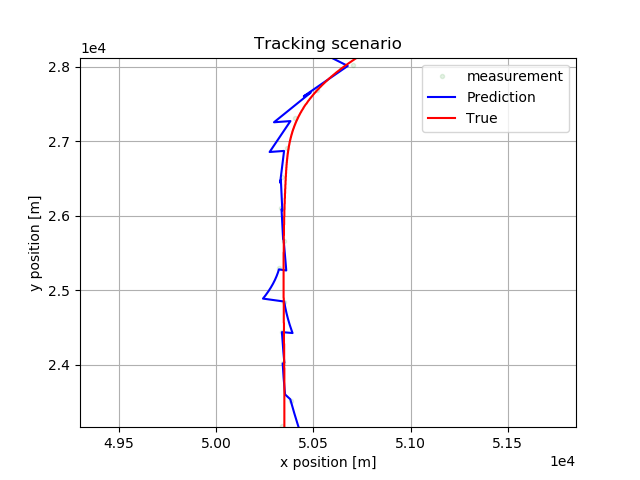

In [157]:
plot_scenario(data, order=order)

<IPython.core.display.Javascript object>


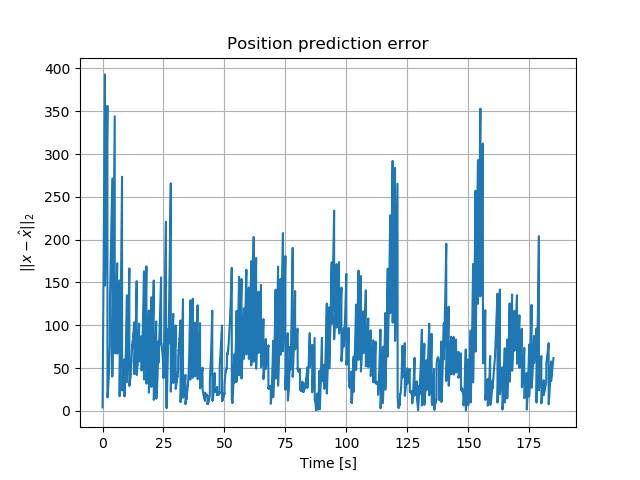

In [158]:
plot_prediction_error(data, np.arange(horizon)*dt, order)